In [1]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from skimpy import skim
import statsmodels.api as sm
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import (fbeta_score, 
                             confusion_matrix, classification_report, 
                             precision_recall_curve)
from collections import Counter
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pl.read_csv("Phising_Detection_Dataset.csv")

data.head()

,NumDots,UrlLength,NumDash,AtSymbol,IpAddress,HttpsInHostname,PathLevel,PathLength,NumNumericChars,Phising
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64
0,3,72,0,0,0,0,5,44,0,1.0
1,3,144,0,0,0,0,3,16,41,1.0
2,3,58,0,0,0,0,2,24,0,1.0
3,3,79,1,0,0,0,6,50,0,1.0
4,3,46,0,0,0,0,4,29,2,1.0


In [3]:
skim(data)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 662591 │ │ int32       │ 10    │                                                          │
│ │ Number of columns │ 11     │ │ float64     │ 1     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name       ┃ NA     ┃ NA %  ┃ mean    ┃ sd      ┃ p0  ┃ p25     ┃ p50    ┃ p75    ┃ p100   ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━┩  │
│ │                   │      0 │     0 │  330000 │  190000 │   0 │  170000 │ 330000 │ 500000 │ 660000 │ ▇▇▇▇▇▇ │  │
│ │ NumDots           │      0 │     0 │     2.2 │     1.5 │   0 │       1 │      2 │      3 │     42 │   ▇    │  │
│ │ UrlLength         │      0 │     0 │      60 │      45 │   1 │      32 │     48 │     77 │   2200 │   ▇    │  │
│ │ NumDash           │      0 │     0 │     1.6 │       3 │   0 │       0 │      0 │      2 │     87 │   ▇    │  │
│ │ AtSymbol          │      0 │     0 │  0.0022 │   0.054 │   0 │       0 │      0 │      0 │     10 │   ▇    │  │
│ │ IpAddress         │      0 │     0 │   0.011 │    0.11 │   0 │       0 │      0 │      0 │      1 │   ▇    │  │
│ │ HttpsInHostname   │      0 │     0 │   0.026 │    0.16 │   0 │       0 │      0 │      0 │      5 │   ▇    │  │
│ │ PathLevel         │      0 │     0 │     2.8 │     1.6 │   0 │       2 │      3 │      4 │     38 │   ▇    │  │
│ │ PathLength        │      0 │     0 │      41 │      30 │   0 │      21 │     35 │     53 │   2200 │   ▇    │  │
│ │ NumNumericChars   │      0 │     0 │    0.65 │     1.4 │   0 │       0 │      1 │      1 │    110 │   ▇    │  │
│ │ Phising           │  32520 │  4.91 │    0.16 │    0.37 │   0 │       0 │      0 │      0 │      1 │ ▇    ▂ │  │
│ └───────────────────┴────────┴───────┴─────────┴─────────┴─────┴─────────┴────────┴────────┴────────┴────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

In [4]:
data = data.drop_nulls()
data.head()

,NumDots,UrlLength,NumDash,AtSymbol,IpAddress,HttpsInHostname,PathLevel,PathLength,NumNumericChars,Phising
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64
0,3,72,0,0,0,0,5,44,0,1.0
1,3,144,0,0,0,0,3,16,41,1.0
2,3,58,0,0,0,0,2,24,0,1.0
3,3,79,1,0,0,0,6,50,0,1.0
4,3,46,0,0,0,0,4,29,2,1.0


In [5]:
data = data.drop('')
data.head()

NumDots,UrlLength,NumDash,AtSymbol,IpAddress,HttpsInHostname,PathLevel,PathLength,NumNumericChars,Phising
i64,i64,i64,i64,i64,i64,i64,i64,i64,f64
3,72,0,0,0,0,5,44,0,1.0
3,144,0,0,0,0,3,16,41,1.0
3,58,0,0,0,0,2,24,0,1.0
3,79,1,0,0,0,6,50,0,1.0
3,46,0,0,0,0,4,29,2,1.0


In [6]:
numeric_features = ['NumDots', 'UrlLength', 'NumDash', 'AtSymbol', 
                    'PathLength', 'NumNumericChars', 'HttpsInHostname']
categoric_features = ['IpAddress', 'PathLevel', 'Phising']

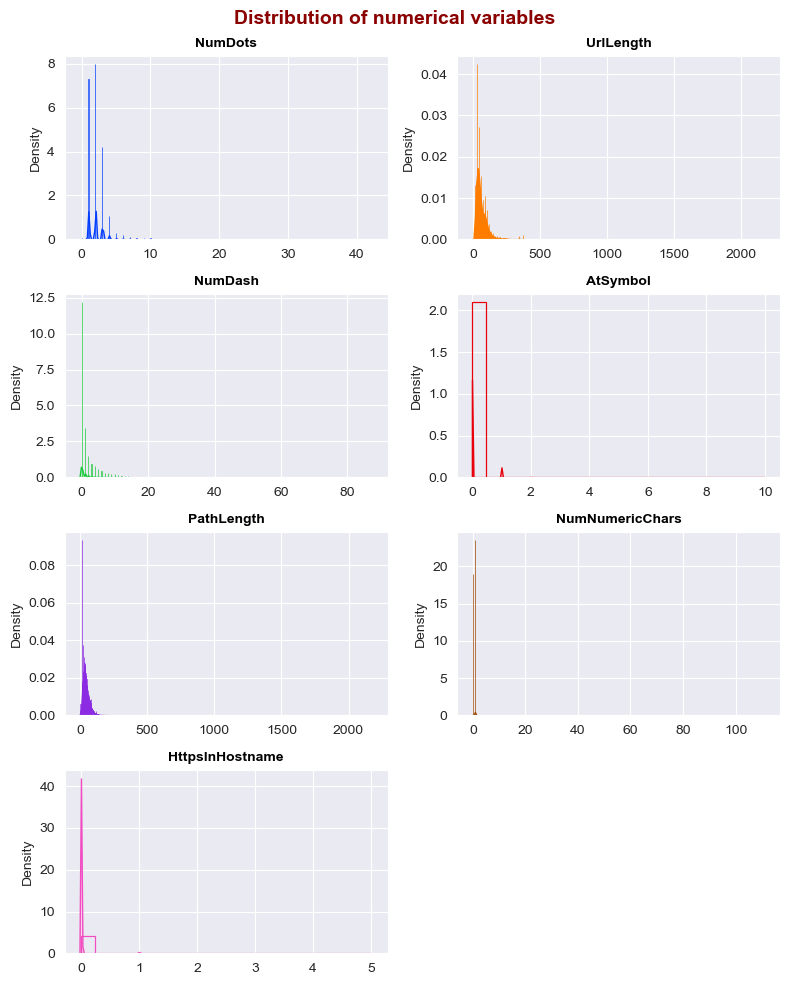

In [7]:
sns.set_style("darkgrid")
colors = sns.color_palette(palette = 'bright', n_colors = len(numeric_features))

fig,axs = plt.subplots(nrows = 4, ncols = 2, figsize = (8,10))
axs = axs.flat

for i,feature in enumerate(numeric_features):
    sns.kdeplot(data, x = feature, color = colors[i], fill = True, ax = axs[i])
    sns.histplot(data, x = feature, stat = 'density', color = colors[i], fill = False, ax = axs[i])
    axs[i].set_xlabel("")
    axs[i].set_title(feature, fontsize = 10, fontweight = 'bold', color = 'black')
    
fig.suptitle("Distribution of numerical variables", fontsize = 14, fontweight = 'bold', color = 'darkred')
fig.delaxes(ax = axs[7])
fig.tight_layout()
fig.show()

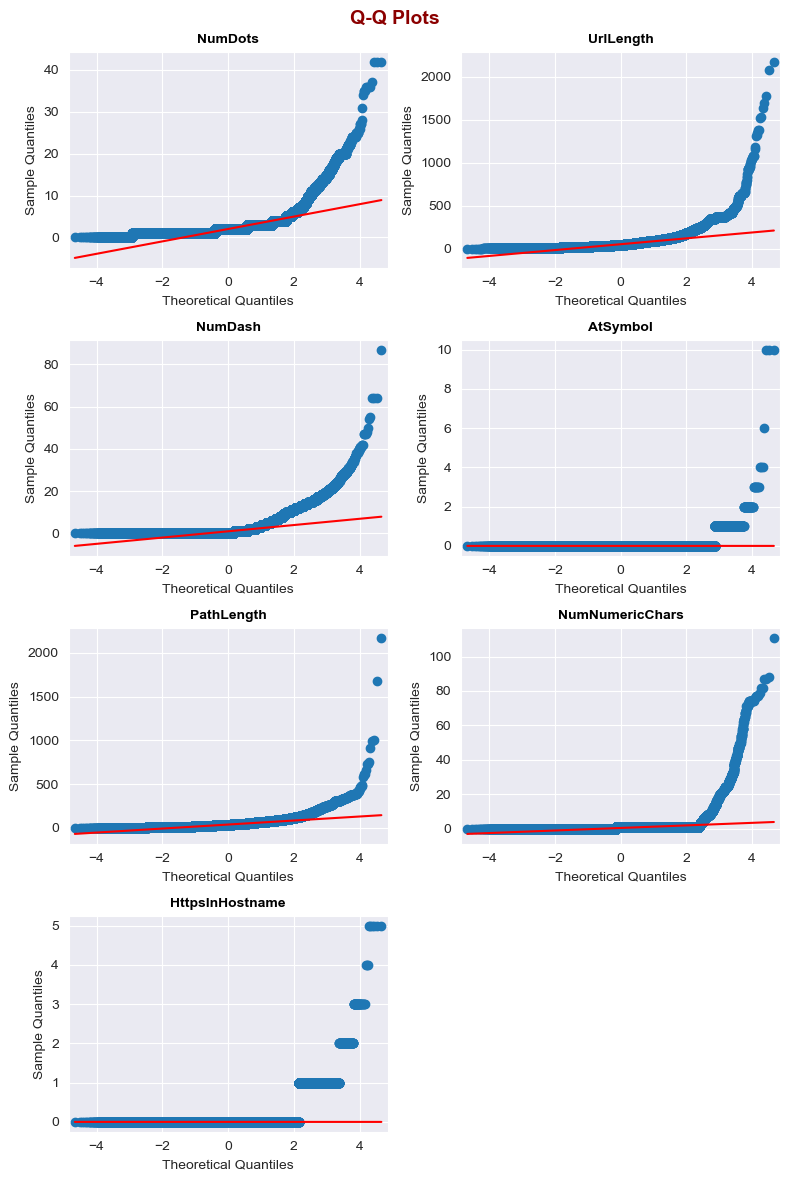

In [8]:
fig,axs = plt.subplots(nrows = 4, ncols = 2, figsize = (8,12))
axs = axs.flat

for i,feature in enumerate(numeric_features):
    sm.qqplot(data[feature], line = 'q', ax = axs[i])
    axs[i].set_title(feature, fontsize = 10, fontweight = 'bold', color = 'black')
    
fig.suptitle("Q-Q Plots", fontsize = 14, fontweight = 'bold', color = 'darkred')
fig.delaxes(ax = axs[7])
fig.tight_layout()
fig.show()

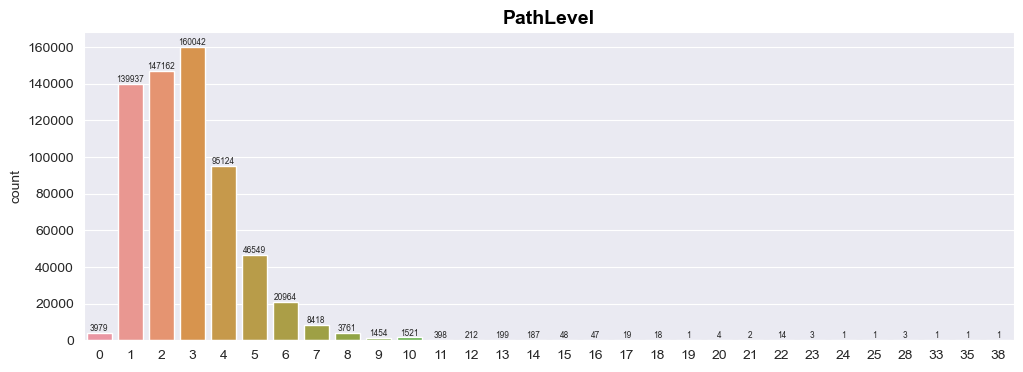

In [10]:
fig,ax = plt.subplots(figsize = (12, 4))
ax = sns.countplot(data.to_pandas(), x = categoric_features[1])

for bars in ax.containers:
    ax.bar_label(bars, fontsize = 6)

ax.set_xlabel("")
ax.set_title(categoric_features[1], fontsize = 14, fontweight = 'bold', color = 'black')
fig.show()


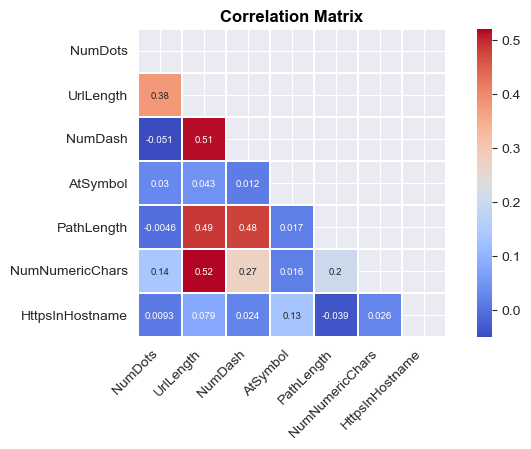

In [12]:
corr_matrix = data[numeric_features].to_pandas().corr(method = 'spearman')
mask = np.triu(np.ones_like(corr_matrix, dtype = bool))

fig,ax = plt.subplots(figsize = (8,4))
sns.heatmap(corr_matrix, 
            cmap = 'coolwarm', 
            annot = True, 
            annot_kws = dict(fontsize = 7),
            linewidths = 1.1, 
            square = True, 
            mask = mask, 
            ax = ax)

ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, horizontalalignment = 'right')
ax.set_title("Correlation Matrix", fontsize = 12, fontweight = 'bold', color = 'black')
fig.show()

In [13]:
TARGET_VARIABLE = 'Phising'
TEST_SIZE = 0.2
SEED = 42

X = data.drop(TARGET_VARIABLE)
y = data[TARGET_VARIABLE]

X_train, X_test, y_train, y_test = tts(X.to_pandas(), 
                                       y.to_pandas(), 
                                       test_size = TEST_SIZE, 
                                       random_state = SEED, 
                                       stratify = y)

In [14]:
print(f'y_train: {Counter(y_train)}')
print(f'y_test: {Counter(y_test)}')

y_train: Counter({0.0: 424047, 1.0: 80009})
y_test: Counter({0.0: 106013, 1.0: 20002})


In [15]:
numeric_predictors = ['NumDots', 'UrlLength', 'NumDash', 'AtSymbol', 'PathLength', 
                      'NumNumericChars', 'HttpsInHostname']

In [16]:
TRANSFORMER = [('scaler', StandardScaler(), numeric_predictors)]

preprocessor = ColumnTransformer(transformers = TRANSFORMER, 
                                 remainder = 'passthrough', 
                                 n_jobs = -1, 
                                 verbose_feature_names_out = False).set_output(transform = 'polars')

X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

In [17]:
clf1 = LogisticRegression(random_state = SEED, 
                          class_weight = 'balanced',
                          max_iter = 1000,
                          n_jobs = -1)

clf2 = RandomForestClassifier(random_state = SEED, 
                              class_weight = 'balanced',
                              n_jobs = -1)

clf3 = ExtraTreesClassifier(bootstrap = True, 
                            class_weight = 'balanced',
                            random_state = SEED, 
                            n_jobs = -1)

clf4 = HistGradientBoostingClassifier(random_state = SEED, 
                                      class_weight = 'balanced')

clf5 = XGBClassifier(random_state = SEED, 
                     scale_pos_weight = Counter(y_train)[0] / Counter(y_train)[1],
                     n_jobs = -1)
clf6 = LGBMClassifier(random_state = SEED, 
                      class_weight = 'balanced',
                      n_jobs = -1, 
                      verbosity = -1)

clf7 = CatBoostClassifier(random_state = SEED, 
                           auto_class_weights = 'Balanced',
                           verbose = 0)

MODELS = [clf1, 
          clf2, 
          clf3, 
          clf4, 
          clf5, 
          clf6, 
          clf7]

In [18]:
for model in tqdm(MODELS):
    name = type(model).__name__
    
    if name == 'LogisticRegression':
        model.fit(X_train_prep.to_numpy(), y_train.values)

        y_pred_train = model.predict(X_train_prep.to_numpy())
        y_pred_test = model.predict(X_test_prep.to_numpy())
        
    else:
        model.fit(X_train.to_numpy(), y_train.values)

        y_pred_train = model.predict(X_train.to_numpy())
        y_pred_test = model.predict(X_test.to_numpy())
    
    score_train = fbeta_score(y_train.values, y_pred_train, beta = 2)
    score_test = fbeta_score(y_test.values, y_pred_test, beta = 2)
    
    print("==" * 30)
    print(f"\033[1;33m {name} \033[0;m :\n") 
    print(f' F2 Train: {score_train:.4f} |', 
          f'F2 Test: {score_test:.4f}\n')
    print("==" * 30)

  0%|          | 0/7 [00:00<?, ?it/s]

 LogisticRegression  :

 F2 Train: 0.5820 | F2 Test: 0.5797

 RandomForestClassifier  :

 F2 Train: 0.7807 | F2 Test: 0.7093

 ExtraTreesClassifier  :

 F2 Train: 0.7808 | F2 Test: 0.7086

 HistGradientBoostingClassifier  :

 F2 Train: 0.7084 | F2 Test: 0.7066

 XGBClassifier  :

 F2 Train: 0.7219 | F2 Test: 0.7148

 LGBMClassifier  :

 F2 Train: 0.7079 | F2 Test: 0.7061

 CatBoostClassifier  :

 F2 Train: 0.7295 | F2 Test: 0.7201



In [19]:
y_pred_train_final = clf7.predict(X_train.to_numpy())
y_pred_test_final = clf7.predict(X_test.to_numpy())

y_pred_prob_train = clf7.predict_proba(X_train.to_numpy())[:,1]
y_pred_prob_test = clf7.predict_proba(X_test.to_numpy())[:,1]

In [20]:
print("##" * 40)
print(" " * 25, "Classification Report Train")
print("##" * 40)
print(classification_report(y_train, y_pred_train_final))
print("")

print("##" * 40)
print(" " * 25, "Classification Report Test")
print("##" * 40)
print(classification_report(y_test, y_pred_test_final))


################################################################################
                          Classification Report Train
################################################################################
              precision    recall  f1-score   support

         0.0       0.97      0.80      0.87    424047
         1.0       0.45      0.87      0.59     80009

    accuracy                           0.81    504056
   macro avg       0.71      0.83      0.73    504056
weighted avg       0.89      0.81      0.83    504056


################################################################################
                          Classification Report Test
################################################################################
              precision    recall  f1-score   support

         0.0       0.97      0.79      0.87    106013
         1.0       0.44      0.86      0.58     20002

    accuracy                           0.80    126015
   macro avg       0.70

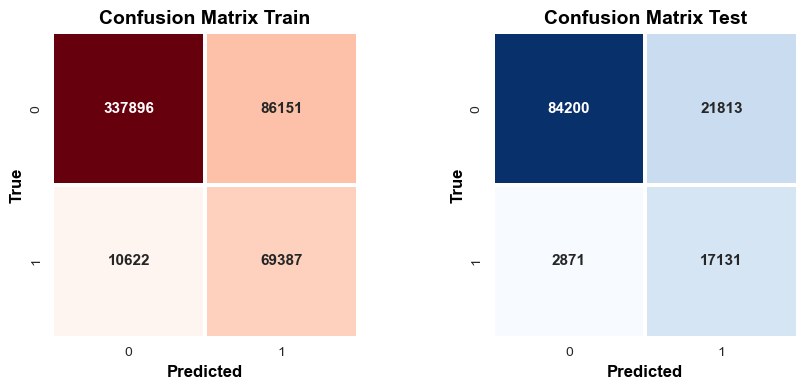

In [21]:
cf_mx_train = confusion_matrix(y_train, y_pred_train_final)
cf_mx_test = confusion_matrix(y_test, y_pred_test_final)

fig,axs = plt.subplots(nrows = 1, ncols = 2, figsize = (9,4))
axs = axs.flat

sns.heatmap(cf_mx_train, cmap = 'Reds', annot = True, annot_kws = {'fontsize':11, 'fontweight':'bold'}, linewidths = 1.5, fmt = '', cbar = False, square = True, ax = axs[0])
sns.heatmap(cf_mx_test, cmap = 'Blues', annot = True, annot_kws = {'fontsize':11, 'fontweight':'bold'}, linewidths = 1.5, fmt = '', cbar = False, square = True, ax = axs[1])
axs[0].set_xlabel('Predicted', fontsize = 12, fontweight = "bold", color = "black")
axs[1].set_xlabel('Predicted', fontsize = 12, fontweight = "bold", color = "black")
axs[0].set_ylabel('True', fontsize = 12, fontweight = "bold", color = "black")
axs[1].set_ylabel('True', fontsize = 12, fontweight = "bold", color = "black")
axs[0].set_title('Confusion Matrix Train', fontsize = 14, fontweight = "bold", color = "black")
axs[1].set_title('Confusion Matrix Test', fontsize = 14, fontweight = "bold", color = "black")

fig.tight_layout()
fig.show()

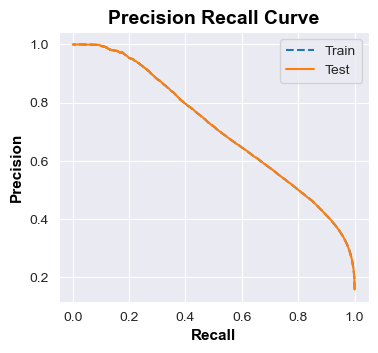

In [22]:
precision_train, recall_train, _ = precision_recall_curve(y_train, 
                                                          y_pred_prob_train)
precision_test, recall_test, _ = precision_recall_curve(y_train, 
                                                        y_pred_prob_train)

plt.figure(figsize = (4,3.5))
plt.plot(recall_train, precision_train, linestyle = '--', label = 'Train')
plt.plot(recall_test, precision_test, label = 'Test')
plt.xlabel("Recall", fontsize = 11, fontweight = 'bold', color = 'black')
plt.ylabel("Precision", fontsize = 11, fontweight = 'bold', color = 'black')
plt.title("Precision Recall Curve", fontsize = 14, fontweight = 'bold', color = 'black')
plt.legend()
plt.show()